In [1]:
import numpy as np
import astropy.io.fits as afits
import matplotlib.pyplot as plt
import apogee.tools.read as apread
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples
from sklearn.metrics.pairwise import euclidean_distances
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from apogee.tools.path import change_dr

In [3]:
def membercount(labels):
    """
    For a list of labels, return the number of objects with each label.

    labels:   label for each object of interest

    Returns membership for each label and the corresponding labels.
    """
    ulab = np.unique(labels)
    members = np.zeros(len(ulab))
    for u in range(len(ulab)):
        members[u] = len(np.where(labels==ulab[u])[0])
    return members,ulab

def sortmembercount(labels):
    """
    For a list of labels, return the number of objects with each label sorted
    so the largest group is first.        
                                                                               
    labels:   label for each object of interest                                
                                                                            
    Returns sorted membership for each label and the corresponding labels. 
    """
    ulab = np.unique(labels)
    members = np.zeros(len(ulab))
    for u in range(len(ulab)):
        members[u] = len(np.where(labels==ulab[u])[0])
    sizelist = np.argsort(members)[::-1]
    return members[sizelist],ulab[sizelist]

def crossmatch(labels_pred,labels_true,minmembers=1):
    """
    Match each found cluster to the original cluster that contributed the 
    majority of its members.

    labels_pred:   Labels for each object matching to found clusters.
    labels_true:   Labels for each object matching to the original clusters.
    minmembers:   Only consider clusters larger than the given size.

    Returns list of found labels and matched true labels.
    """
    plabs = (np.unique(labels_pred)).astype(int)
    bad = np.where(plabs==-1)
    if len(bad[0])>0:
        plabs = np.delete(plabs,bad[0][0])
    tlabs = -np.ones(plabs.shape,dtype=int)
    for p in range(len(plabs)):
        predmatch = np.where(labels_pred==plabs[p])
        if len(labels_pred[predmatch])>=minmembers:
            truepredmatch = labels_true[predmatch]
            truecounts,trueinds = sortmembercount(truepredmatch)
            tlabs[p]=trueinds[0] #stands for majority stakeholder
    return plabs,tlabs
    
def efficiency_completeness(labels_pred,
                            labels_true,
                            minmembers=1):
    """
    Compute the efficiency and completeness for each cluster in a sample.

    labels_pred:   Labels for each object matching to found clusters.         
    labels_true:   Labels for each object matching to the original clusters.    
    minmembers:   Only consider clusters larger than the given size.  
    
    Returns lists of efficiency, completeness, found labels and 
    matched true labels.
    """
    plabs,tlabs = crossmatch(labels_pred,labels_true,minmembers=minmembers)
    bad = np.where(plabs==-1)
    if len(bad[0])>0:
        plabs = np.delete(plabs,bad[0][0])
    # Initialize output as disallowed values.
    efficiency = -np.ones(plabs.shape)
    completeness = -np.ones(plabs.shape)
    # Go through all found clusters
    for p in range(len(plabs)):
        predmatch = np.where(labels_pred==plabs[p])
        pred_pred = labels_pred[predmatch]
        true_pred = labels_true[predmatch]
        # Proceed if cluster is large enough
        if len(pred_pred)>=minmembers:
            # Find all members of the matched original cluster
            truematch = np.where(labels_true==tlabs[p])
            true_true = labels_true[truematch]
            # Find all members of the matched original cluster in the 
            # found cluster
            predtruematch = np.where((labels_true==tlabs[p]) & (labels_pred==plabs[p]))
            pred_predtrue = labels_pred[predtruematch]
            # Find the number of stars in the found cluster
            Nrecover = len(pred_pred)
            # Find the number of stars in the original cluster
            Noriginal = len(true_true)
            # Find the number of stars of the original cluster in the 
            # found cluster
            Nmajority = len(pred_predtrue)
            # Find efficiency and completeness
            efficiency[p] = Nmajority/Nrecover
            completeness[p] = Nmajority/Noriginal
    return efficiency, completeness, plabs, tlabs

In [4]:
change_dr('14')

In [5]:
allStar= apread.allStar(use_astroNN=True)

/home/price-jones/local/lib/python3.6/site-packages/apogee-1.-py3.6.egg/apogee/tools/read.py:1138: UserWarning: Swapping in stellar parameters and abundances from Leung & Bovy (2019a)
  warnings.warn("Swapping in stellar parameters and abundances from Leung & Bovy (2019a)")
/home/price-jones/local/lib/python3.6/site-packages/apogee-1.-py3.6.egg/apogee/tools/read.py:1141: UserWarning: Adding distances from Leung & Bovy (2019b)
  warnings.warn("Adding distances from Leung & Bovy (2019b)")
/home/price-jones/local/lib/python3.6/site-packages/apogee-1.-py3.6.egg/apogee/tools/read.py:1144: UserWarning: Adding ages from Mackereth, Bovy, Leung, et al. (2019)
  warnings.warn("Adding ages from Mackereth, Bovy, Leung, et al. (2019)")


In [6]:
allStar.dtype

dtype([('APSTAR_ID', 'S45'), ('TARGET_ID', 'S34'), ('ASPCAP_ID', 'S46'), ('FILE', 'S38'), ('APOGEE_ID', 'S18'), ('TELESCOPE', 'S8'), ('LOCATION_ID', '>i2'), ('FIELD', 'S16'), ('J', '>f4'), ('J_ERR', '>f4'), ('H', '>f4'), ('H_ERR', '>f4'), ('K', '>f4'), ('K_ERR', '>f4'), ('RA', '>f8'), ('DEC', '>f8'), ('GLON', '>f8'), ('GLAT', '>f8'), ('APOGEE_TARGET1', '>i4'), ('APOGEE_TARGET2', '>i4'), ('APOGEE_TARGET3', '>i4'), ('TARGFLAGS', 'S140'), ('SURVEY', 'S14'), ('NINST', '>i4', (3,)), ('NVISITS', '>i4'), ('COMBTYPE', '>i4'), ('COMMISS', '>i2'), ('SNR', '>f4'), ('STARFLAG', '>i4'), ('STARFLAGS', 'S165'), ('ANDFLAG', '>i4'), ('ANDFLAGS', 'S74'), ('VHELIO_AVG', '>f4'), ('VSCATTER', '>f4'), ('VERR', '>f4'), ('VERR_MED', '>f4'), ('OBSVHELIO_AVG', '>f4'), ('OBSVSCATTER', '>f4'), ('OBSVERR', '>f4'), ('OBSVERR_MED', '>f4'), ('SYNTHVHELIO_AVG', '>f4'), ('SYNTHVSCATTER', '>f4'), ('SYNTHVERR', '>f4'), ('SYNTHVERR_MED', '>f4'), ('RV_TEFF', '>f4'), ('RV_LOGG', '>f4'), ('RV_FEH', '>f4'), ('RV_ALPHA', '>f4'

In [8]:
def gen_condition(elems,uplim,downlim,snrlim):
    good = (allStar['SNR']>snrlim)
    for elem in elems:
        if elem != 'FE':
            suff = 'FE'
        elif elem == 'FE':
            suff = 'H'
        good = good & (allStar['{0}_{1}_ERR'.format(elem,suff)] < uplim) & (allStar['{0}_{1}_ERR'.format(elem,suff)] > downlim)
    return good

C_FE_ERR
N_FE_ERR
O_FE_ERR
MG_FE_ERR
AL_FE_ERR
SI_FE_ERR
K_FE_ERR
CA_FE_ERR
FE_H_ERR
NI_FE_ERR


(array([4.0054e+04, 1.4589e+04, 4.8850e+03, 1.9470e+03, 8.1400e+02,
        3.2200e+02, 1.2300e+02, 1.8000e+01, 1.1000e+01, 3.0000e+00]),
 array([  50.02899933,  251.91608963,  453.80317993,  655.69027023,
         857.57736053, 1059.46445084, 1261.35154114, 1463.23863144,
        1665.12572174, 1867.01281204, 2068.89990234]),
 <a list of 10 Patch objects>)

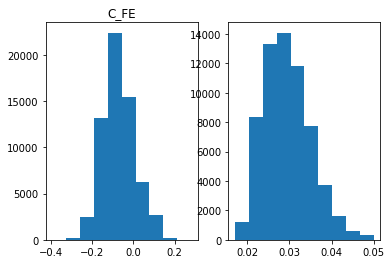

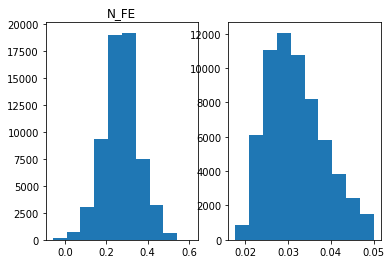

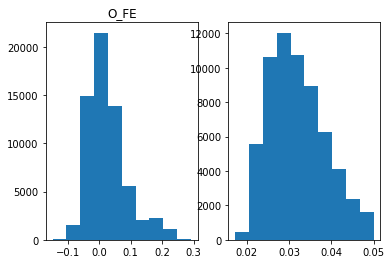

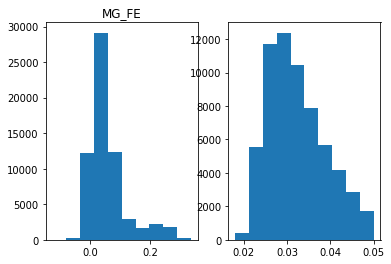

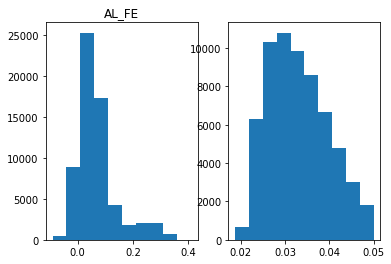

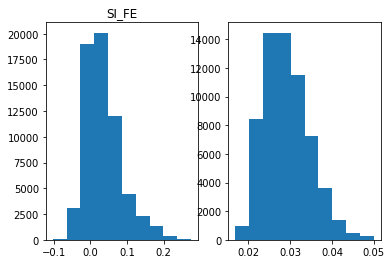

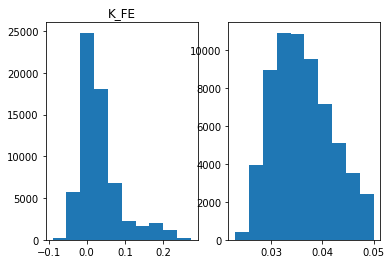

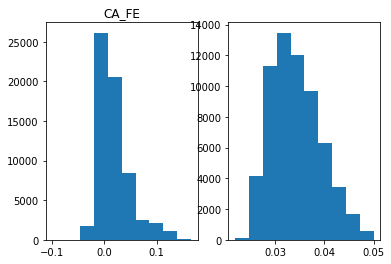

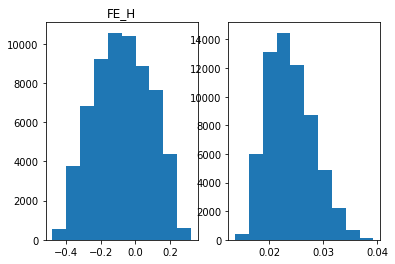

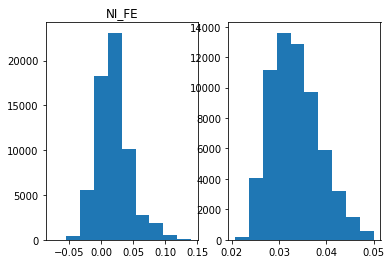

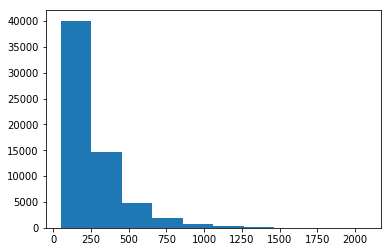

In [9]:
#elems = ['C','N','O','MG','AL','SI','P','S','K','CA','TI','V','CR','MN','FE','CO','NI']
elems = ['C','N','O','MG','AL','SI','S','K','CA','TI','V','CR','MN','FE','NI']
elems = ['C','N','O','MG','AL','SI','K','CA','FE','NI']
def gen_condition(elems,uplim,downlim,snrlim):
    good = (allStar['SNR']>snrlim)
    for elem in elems:
        if elem != 'FE':
            suff = 'FE'
        elif elem == 'FE':
            suff = 'H'
        print('{0}_{1}_ERR'.format(elem,suff))
        good = good & (allStar['{0}_{1}_ERR'.format(elem,suff)] < uplim) & (allStar['{0}_{1}_ERR'.format(elem,suff)] > downlim)
    return good
keys = []
uplim = 0.05
downlim = -1000
#goodstars = (allStar['SNR'] > 50) & (allStar['C_FE_ERR'] < uplim) & (allStar['C_FE_ERR'] > downlim) & (allStar['N_FE_ERR'] < uplim) & (allStar['N_FE_ERR'] > downlim) & (allStar['O_FE_ERR'] < uplim) & (allStar['O_FE_ERR'] > downlim) & (allStar['MG_FE_ERR'] < uplim) & (allStar['MG_FE_ERR'] > downlim) & (allStar['AL_FE_ERR'] < uplim) & (allStar['AL_FE_ERR'] > downlim) & (allStar['SI_FE_ERR'] < uplim) & (allStar['SI_FE_ERR'] > downlim) & (allStar['P_FE_ERR'] < uplim) & (allStar['P_FE_ERR'] > downlim) & (allStar['K_FE_ERR'] < uplim) & (allStar['K_FE_ERR'] > downlim) & (allStar['CA_FE_ERR'] < uplim) & (allStar['CA_FE_ERR'] > downlim) & (allStar['TI_FE_ERR'] < uplim) & (allStar['TI_FE_ERR'] > downlim) & (allStar['V_FE_ERR'] < uplim) & (allStar['V_FE_ERR'] > downlim) & (allStar['CR_FE_ERR'] < uplim) & (allStar['CR_FE_ERR'] > downlim) & (allStar['MN_FE_ERR'] < uplim) & (allStar['MN_FE_ERR'] > downlim) & (allStar['FE_H_ERR'] < uplim) & (allStar['FE_H_ERR'] > downlim) & (allStar['CO_FE_ERR'] < uplim) & (allStar['CO_FE_ERR'] > downlim) & (allStar['NI_FE_ERR'] < uplim) & (allStar['NI_FE_ERR'] > downlim) 
#goodstars = (allStar['SNR'] > 50) & (allStar['C_FE_ERR'] < uplim) & (allStar['C_FE_ERR'] > downlim) & (allStar['N_FE_ERR'] < uplim) & (allStar['N_FE_ERR'] > downlim) & (allStar['O_FE_ERR'] < uplim) & (allStar['O_FE_ERR'] > downlim) & (allStar['MG_FE_ERR'] < uplim) & (allStar['MG_FE_ERR'] > downlim) & (allStar['AL_FE_ERR'] < uplim) & (allStar['AL_FE_ERR'] > downlim) & (allStar['SI_FE_ERR'] < uplim) & (allStar['SI_FE_ERR'] > downlim) & (allStar['K_FE_ERR'] < uplim) & (allStar['K_FE_ERR'] > downlim) & (allStar['CA_FE_ERR'] < uplim) & (allStar['CA_FE_ERR'] > downlim) & (allStar['TI_FE_ERR'] < uplim) & (allStar['TI_FE_ERR'] > downlim) & (allStar['V_FE_ERR'] < uplim) & (allStar['V_FE_ERR'] > downlim) & (allStar['CR_FE_ERR'] < uplim) & (allStar['CR_FE_ERR'] > downlim) & (allStar['MN_FE_ERR'] < uplim) & (allStar['MN_FE_ERR'] > downlim) & (allStar['FE_H_ERR'] < uplim) & (allStar['FE_H_ERR'] > downlim) & (allStar['NI_FE_ERR'] < uplim) & (allStar['NI_FE_ERR'] > downlim) 
goodstars = gen_condition(elems,uplim,downlim,50)
#goodstars = allStar['SNR'] > 50
for elem in elems:
    if elem !='FE':
        key = '{0}_FE'.format(elem)
    if elem == 'FE':
        key = 'FE_H'
    keys.append(key)
    data = allStar[key]
    err = allStar['{0}_ERR'.format(key)]
    mask = (err > -1000) & (err < 0.05)
    plt.figure()
    plt.subplot(121)
    plt.title(key)
    plt.hist(data[goodstars])
    plt.subplot(122)
    plt.hist(err[goodstars])
   
plt.figure()
plt.hist(allStar['SNR'][goodstars])

In [10]:
abundances = np.zeros((len(allStar[goodstars]),len(keys)),dtype=float)
#spectra = np.zeros()
for k,key in enumerate(keys):
    abundances[:,k] = allStar[goodstars][key]

In [ ]:
twod = TSNE(n_components=2).fit_transform(abundances)

In [11]:
maxval=int(3e4)
dists = euclidean_distances(abundances,abundances)

In [12]:
typ = np.median(dists)

In [13]:
typ

0.28420236513373376

In [14]:
# 0.15 - 0.17 seems to do the trick, as predicted for the optimistic case from paper when using 17 elems
# 15 elems? - 0.125
scalerange = np.arange(0.08,0.11,0.001)
labellist = []
for scale in scalerange:
    print(scale)
    db = DBSCAN(min_samples=3,
                eps=scale*typ,n_jobs=1,
                metric='precomputed').fit(dists)
    labellist.append(db.labels_)
    

0.08
0.081
0.082
0.083
0.084
0.085
0.08600000000000001
0.08700000000000001
0.08800000000000001
0.08900000000000001
0.09000000000000001
0.09100000000000001
0.09200000000000001
0.09300000000000001
0.09400000000000001
0.09500000000000001
0.09600000000000002
0.09700000000000002
0.09800000000000002
0.09900000000000002
0.10000000000000002
0.10100000000000002
0.10200000000000002
0.10300000000000002
0.10400000000000002
0.10500000000000002
0.10600000000000002
0.10700000000000003
0.10800000000000003
0.10900000000000003


In [15]:

pcountls = []
plabls = []
csils = []
for l,labs in enumerate(labellist):
    print(l+1,len(scalerange))
    pcount,plabs = membercount(labs)
    minsize=9
    sils = silhouette_samples(abundances,labs)
    clustersils = np.array([np.mean(sils[labs==lab]) for lab in plabs])
    goodlabs = (pcount>=minsize) & (plabs > -1) & (clustersils > 0)
    csils.append(clustersils)
    pcountls.append(pcount)
    plabls.append(plabs)

1 30
2 30
3 30
4 30
5 30
6 30
7 30
8 30
9 30
10 30
11 30
12 30
13 30
14 30
15 30
16 30
17 30
18 30
19 30
20 30
21 30
22 30
23 30
24 30
25 30
26 30
27 30
28 30
29 30
30 30


In [ ]:
# minsize=10
# for l,labs in enumerate(labellist):
#     clustersils = csils[l]
#     pcount = pcountls[l]
#     plabs = plabls[l]
#     goodlabs = (pcount>=minsize) & (plabs > -1) & (clustersils > 0)
#     plt.figure(figsize=(15,6))
#     ax = plt.subplot(121)
#     ax.set_yscale('log')
#     plt.title('scale = {0}, total groups = {1}, big groups = {2}'.format(scalerange[l],len(plabs)-1,len(plabs[goodlabs])))
#     plt.hist(pcount[plabs>-1],bins = np.arange(np.min(pcount[plabs>-1]),np.max(pcount[plabs>-1])+1))
#     plt.xlabel('group size')
#     plt.ylabel('number of groups')
#     ax = plt.subplot(122)
#     ax.set_yscale('log')
#     plt.hist(pcount[goodlabs],bins = np.arange(np.min(pcount[goodlabs]),np.max(pcount[goodlabs])+1))
#     plt.xlabel('group size')
#     plt.ylabel('number of groups')

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [21]:
scalerange[8]

0.08800000000000001

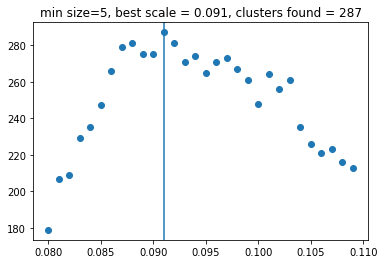

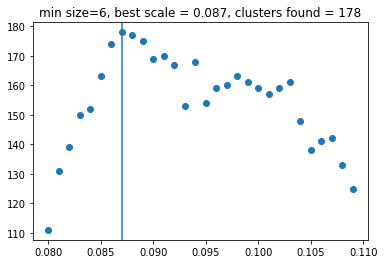

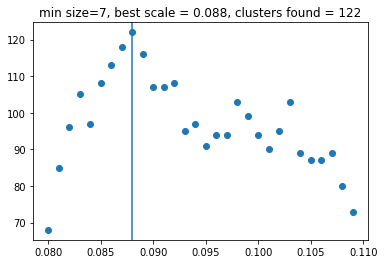

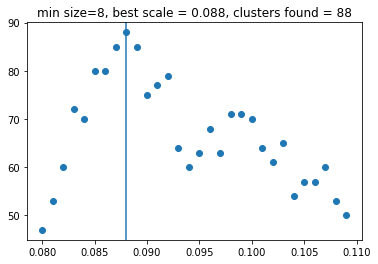

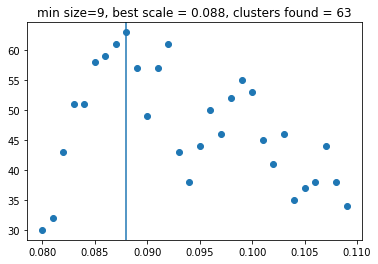

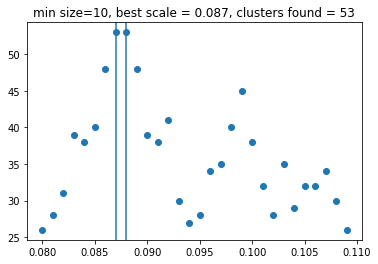

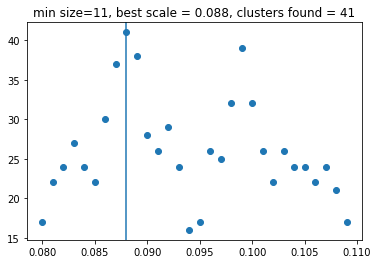

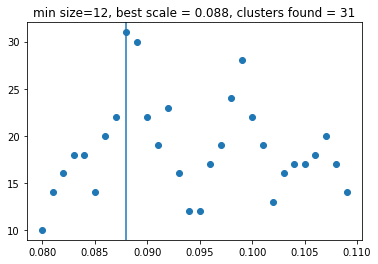

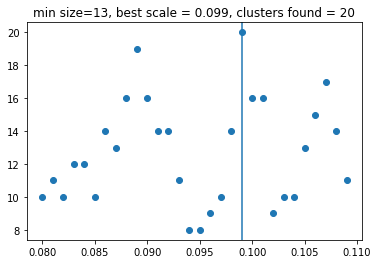

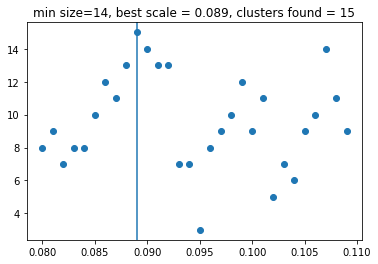

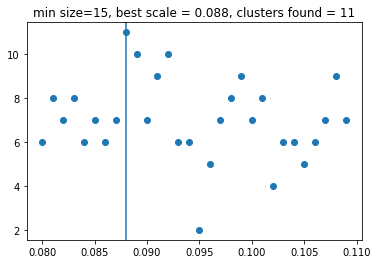

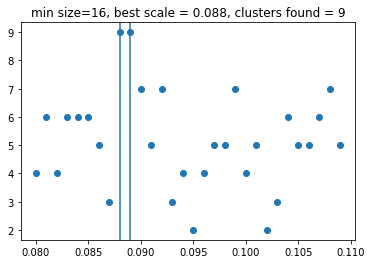

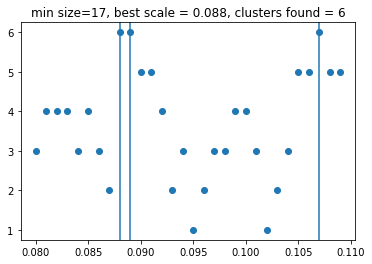

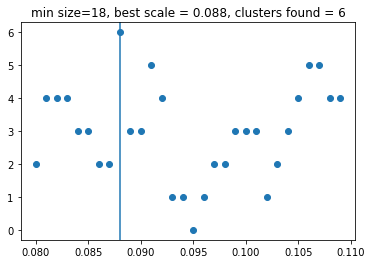

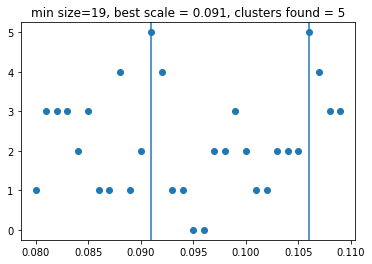

In [16]:
sizes = np.arange(5,20,1)
for minsize in sizes:
    plt.figure()
    nums = np.array([])
    for l,labs in enumerate(labellist):
        clustersils = csils[l]
        pcount = pcountls[l]
        plabs = plabls[l]
        goodlabs = (pcount>=minsize) & (plabs > -1) & (clustersils > 0)
        nums = np.append(nums,len(plabs[goodlabs]))
    maxnum = np.where(nums==np.max(nums))  
    for maxn in maxnum[0]:
        plt.axvline(scalerange[maxn])
    plt.plot(scalerange,nums,'o',color='C0')
    plt.title('min size={0}, best scale = {1}, clusters found = {2}'.format(minsize,np.round(scalerange[maxnum[0][0]],3),int(nums[maxnum[0][0]])))


In [109]:
minsize=5
l = 8
labs = labellist[l]
clustersils = csils[l]
pcount = pcountls[l]
plabs = plabls[l]
goodlabs = (pcount>=minsize) & (plabs > -1) & (clustersils > 0)
goodinds = []
recolour = []
colors = {}
c=0
for l,lab in enumerate(labs):
    if lab in plabs[goodlabs]:
        if lab not in list(colors.keys()):
            c+=1
            colors[lab] = c
        goodinds.append(l)
        recolour.append(colors[lab])

(array([  1.,   3.,   0.,  12.,  28., 107., 359., 479.,  95.,  19.]),
 array([-0.79931526, -0.63801272, -0.47671019, -0.31540765, -0.15410511,
         0.00719742,  0.16849996,  0.32980249,  0.49110503,  0.65240756,
         0.8137101 ]),
 <a list of 10 Patch objects>)

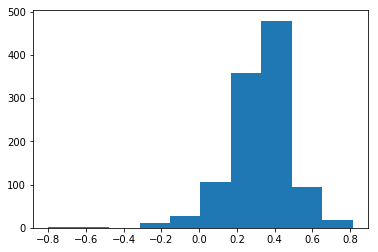

In [110]:
plt.hist(clustersils)

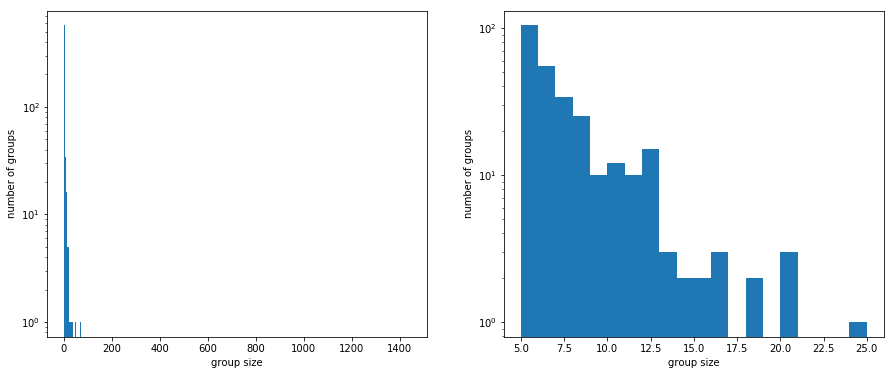

In [111]:
plt.figure(figsize=(15,6))
ax = plt.subplot(121)
ax.set_yscale('log')
plt.hist(pcount[plabs>-1],bins = np.arange(np.min(pcount[plabs>-1]),np.max(pcount[plabs>-1])+1))
plt.xlabel('group size')
plt.ylabel('number of groups')
ax = plt.subplot(122)
ax.set_yscale('log')
plt.hist(pcount[goodlabs],bins = np.arange(np.min(pcount[goodlabs]),np.max(pcount[goodlabs])+1))
plt.xlabel('group size')
plt.ylabel('number of groups')

In [52]:
mem.dtype

dtype((numpy.record, [('CLUSTER', 'S11'), ('APOGEE_ID', 'S18'), ('LOCATION_ID', '>i8'), ('GLON', '>f8'), ('GLAT', '>f8'), ('VHELIO_AVG', '>f8'), ('VSCATTER', '>f8'), ('PMRA', '>f8'), ('PMRA_ERR', '>f8'), ('PMDEC', '>f8'), ('PMDEC_ERR', '>f8'), ('FE_H', '>f8'), ('FE_H_ERR', '>f8'), ('RV_PROB', '>f8'), ('FEH_PROB', '>f8'), ('PM_PROB', '>f8'), ('MEMBER_FLAG', 'S2')]))

In [112]:
cls = afits.open('occam_cluster-DR14.fits')
cls = cls[1].data
mem = afits.open('occam_member-DR14.fits')
mem = mem[1].data
apinds = np.array([],dtype=int)
clinds = np.array([],dtype=int)
for a,apoid in enumerate(mem['APOGEE_ID']):
    if mem['MEMBER_FLAG'][a]=='GM':
        match = np.where(apoid==(allStar[goodstars]['APOGEE_ID']).astype('U100'))
        if len(match[0])>0:
            apinds = np.append(apinds,match[0][0])
            clinds = np.append(clinds,a)
# apoids = np.in1d((allStar['APOGEE_ID'][goodstars]).astype('U100'),mem['APOGEE_ID'])
# memids = np.in1d(mem['APOGEE_ID'],(allStar['APOGEE_ID'][goodstars]).astype('U100'))
# openclschem = allStar[goodstars][apoids]
# opencls = mem[memids]

# ocsort = np.argsort(opencls['APOGEE_ID'])
# occhemsort = np.argsort(openclschem['APOGEE_ID'])
# opencls = opencls[ocsort]
# openclschem = openclschem[occhemsort]
#apoids = np.in1d((openclschem['APOGEE_ID']).astype('U100'),opencls['APOGEE_ID'])

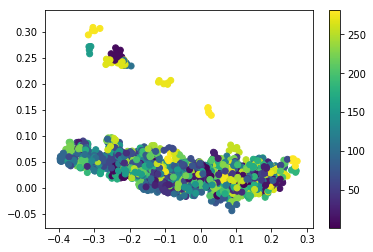

In [113]:
key1 = 'FE_H'
key2 = 'MG_FE'
ind1 = np.where(np.array(keys)==key1)
ind2 = np.where(np.array(keys)==key2)
plt.figure()
sca = plt.scatter(abundances[goodinds][:,ind1][:,0][:,0],abundances[goodinds][:,ind2][:,0][:,0],c=recolour)
plt.colorbar(sca)
# plt.figure(figsize=(20,20))
# p=1

# for key1 in keys:
#     ind1 = np.where(np.array(keys)==key1)
#     for key2 in keys:
#         ind2 = np.where(np.array(keys)==key2)
#         plt.subplot(len(keys),len(keys),p)
#         sca = plt.scatter(abundances[goodinds][:,ind2][:,0][:,0],abundances[goodinds][:,ind1][:,0][:,0],c=recolour)
#         plt.xticks([])
#         plt.yticks([])
#         if p % len(keys)==1:
#             plt.ylabel(key1)
#         if float(p)/len(keys) > len(keys)-1:
#             plt.xlabel(key2)
#         p+=1
# plt.tight_layout()

In [ ]:
## Clusters smeary because I hadn't purged dwarfs

In [114]:
for i,ind in enumerate(apinds):
    if ind in goodinds:
        print('found a member of {0} labelled {1}'.format(mem[clinds[i]]['CLUSTER'],labs[ind]))

found a member of NGC 7789 labelled 341
found a member of NGC 188 labelled 49
found a member of NGC 188 labelled 128
found a member of NGC 188 labelled 49
found a member of Berkeley 17 labelled 168
found a member of NGC 2420 labelled 103
found a member of NGC 2682 labelled 264
found a member of NGC 2682 labelled 658
found a member of NGC 2682 labelled 264
found a member of NGC 2682 labelled 264
found a member of NGC 2682 labelled 381


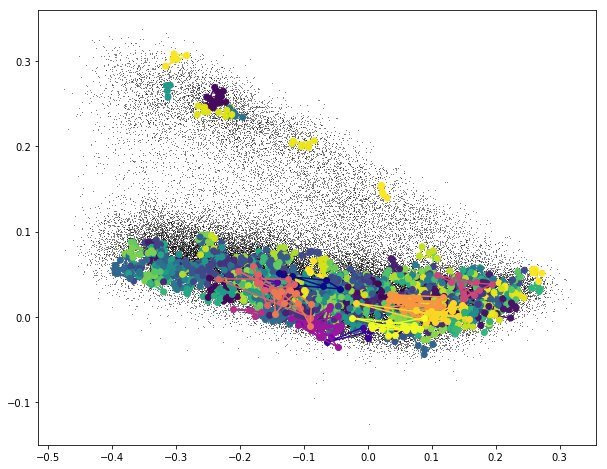

In [115]:
plt.figure(figsize=(10,8))
#sca = plt.scatter(twod[:,0][goodinds],twod[:,1][goodinds],c=recolour,zorder=2)
plotcolors = plt.get_cmap('viridis')(np.unique(recolour)/np.max(recolour))
#sca = plt.scatter(abundances[goodinds][:,ind1][:,0][:,0],abundances[goodinds][:,ind2][:,0][:,0],c=recolour,alpha=0.5)
#plt.plot(twod[:,0],twod[:,1],',',alpha=0.5,zorder=0)
x = abundances[:,ind1][:,0][:,0]
y = abundances[:,ind2][:,0][:,0]
sca = plt.scatter(x[goodinds],y[goodinds],c=recolour,zorder=2)
plt.plot(x,y,'k,',alpha=0.5,zorder=0)
for l,lab in enumerate(plabs[goodlabs]):
    match = np.where(labs==lab)
    cind = np.where(colors[lab]==np.unique(recolour))
    plt.plot(x[match],y[match],color=plotcolors[cind][0],zorder=1)
clslist = np.unique(mem[clinds]['CLUSTER'])
occolors = plt.get_cmap('plasma')(np.linspace(0,1,len(clslist)))
for c,cluster in enumerate(np.unique(mem[clinds]['CLUSTER'])):
    match = np.where(mem[clinds]['CLUSTER']==cluster)
    #plt.figure()
    #plt.title(cluster)
    plt.plot(allStar[goodstars][apinds][key1][match],allStar[goodstars][apinds][key2][match],'o-',color=occolors[c])
    #plt.hist(allStar[goodstars][apinds][key1][match])
#plt.colorbar(sca)